In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd  # Import IPython.display module

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio
import IPython.display as ipd  # Import IPython.display module

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import shutil
import os
from pathlib import Path
import numpy as np
import scipy.signal as signal  # Import signal module from scipy
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
Ravdess_paths = "/content/drive/MyDrive/RAVDESS"
dir_list = os.listdir(Ravdess_paths)
dir_list.sort()
print(dir_list)


['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'audio_song_actors_01-24']


In [ ]:
import os
import pandas as pd

# Création d'un DataFrame pour stocker les informations sur les fichiers audio
ravdess_db = pd.DataFrame(columns=['path', 'source', 'actor', 'gender', 'emotion', 'emotion_lb'])
count = 0

# Tri des répertoires du dataset RAVDESS
dir_list.sort()
for i in dir_list:
    # Parcours des fichiers dans chaque répertoire
    file_list = os.listdir(os.path.join(Ravdess_paths, i))
    for f in file_list:
        # Extraction des informations du nom de fichier
        nm = f.split('.')[0].split('-')
        if len(nm) >= 6:  # Vérification du format du nom de fichier
            # Construction du chemin du fichier
            path = os.path.join(Ravdess_paths, i, f)
            # Extraction du numéro de l'acteur
            actor = int(''.join(filter(str.isdigit, nm[-1])))
            # Extraction de l'émotion
            emotion = int(nm[2])
            # Détermination de la source (Ravdess)
            source = "Ravdess"
            # Détermination du genre en fonction du numéro de l'acteur
            gender = "female" if int(actor) % 2 == 0 else "male"
            # Détermination de l'intensité, de l'affirmation et de la répétition
            intensity = 0 if nm[3] == '01' else 1
            statement = 0 if nm[4] == '01' else 1
            repeat = 0 if nm[5] == '01' else 1
            # Conversion du code d'émotion en libellé correspondant
            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"
            # Ajout des informations extraites au DataFrame
            ravdess_db.loc[count] = [path, source, actor, gender, emotion, lb]
            count += 1


In [ ]:
print (len(ravdess_db))


1012


In [ ]:
ravdess_db.sort_values(by='path',inplace=True)
ravdess_db.index =  range(len(ravdess_db.index))
ravdess_db.head(10)

path   source  actor gender  \
0  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
1  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
2  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
3  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
4  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
5  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
6  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
7  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
8  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   
9  /content/drive/MyDrive/RAVDESS/Actor_01/03-02-...  Ravdess      1   male   

   emotion emotion_lb  
0        1    neutral  
1        1    neutral  
2        1    neutral  
3        1    neutral  
4        2       calm  
5        2       calm  
6        2       calm  
7        2       calm  
8        2       calm  
9        2       calm

In [ ]:
sampling_rate = 44100


In [ ]:
filename = ravdess_db.path[0]
print (filename)

/content/drive/MyDrive/RAVDESS/Actor_01/03-02-01-01-01-01-01.wav


In [ ]:
!pip install resampy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.1 MB/s eta 0:00:00


In [ ]:
!pip install librosa

In [ ]:
# Chargement du fichier audio avec resampling rapide (kaiser_fast) à un taux d'échantillonnage spécifié
# samples contient les échantillons audio et sample_rate contient le taux d'échantillonnage du fichier audio
samples, sample_rate = librosa.load(filename, res_type='kaiser_fast', sr=sampling_rate)

# Affichage du taux d'échantillonnage et de la forme des échantillons
print("Sample Rate:", sample_rate)
print("Shape of samples:", samples.shape)


In [ ]:

# Assuming you have already loaded the audio samples and sample_rate
ipd.Audio(samples, rate=sample_rate)  # Display the audio

**Spectogram**

In [ ]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    """
    Calcul du spectrogramme logarithmique d'un signal audio.

    Arguments:
    - audio: tableau de forme (N,) contenant les échantillons audio.
    - sample_rate: le taux d'échantillonnage du signal audio.
    - window_size: la taille de la fenêtre en millisecondes pour la transformation de Fourier.
    - step_size: le pas de déplacement en millisecondes pour la transformation de Fourier.
    - eps: petit nombre pour éviter les erreurs de logarithme.

    Retour:
    - freqs: tableau 1D contenant les fréquences du spectrogramme.
    - times: tableau 1D contenant les temps correspondant à chaque colonne du spectrogramme.
    - spec_log: spectrogramme logarithmique calculé.
    """
    # Calcul de la longueur de la fenêtre et du chevauchement en fonction des paramètres donnés
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))

    # Calcul du spectrogramme avec la fonction signal.spectrogram de scipy.signal
    freqs, times, spec = signal.spectrogram(audio,
                                             fs=sample_rate,
                                             window='hann',
                                             nperseg=nperseg,
                                             noverlap=noverlap,
                                             detrend=False)

    # Calcul du logarithme du spectrogramme avec un petit epsilon ajouté pour éviter les valeurs nulles
    spec_log = np.log(spec.T.astype(np.float32) + eps)

    return freqs, times, spec_log


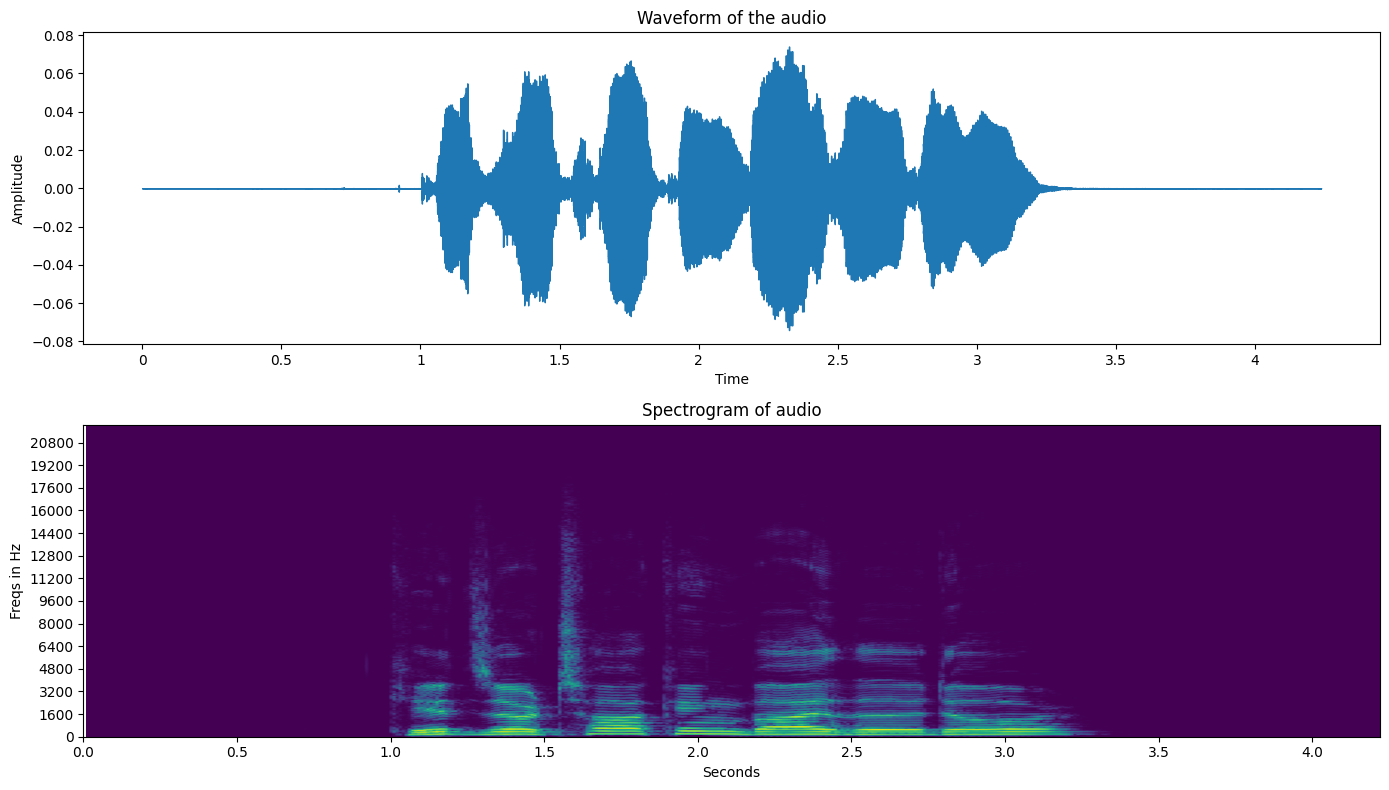

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import librosa.display

# Assuming you have already defined and loaded the variables samples and sample_rate
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))

# Plot waveform
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the audio')
ax1.set_ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

# Plot spectrogram
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

plt.tight_layout()
plt.show()


**Trimming the audio**

In [ ]:
# Réduction du silence initial et final du signal audio
# Utilisation de la fonction librosa.effects.trim pour supprimer les parties silencieuses du signal
# top_db est le seuil en décibels en dessous duquel considérer une partie du signal comme silencieuse
# samples_trim contient le signal audio après la suppression du silence
# index contient les indices de début et de fin des segments non silencieux
samples_trim, index = librosa.effects.trim(samples, top_db=25)


In [ ]:
ipd.Audio(samples_trim,rate=sample_rate)

In [ ]:
Difference_in_length = len(samples)-len(samples_trim)
Difference_in_length

90622

In [ ]:
Difference_in_duration = librosa.get_duration(y=samples) - librosa.get_duration(y=samples_trim)
Difference_in_duration


4.10984126984127

Text(0.5, 0, 'Seconds')

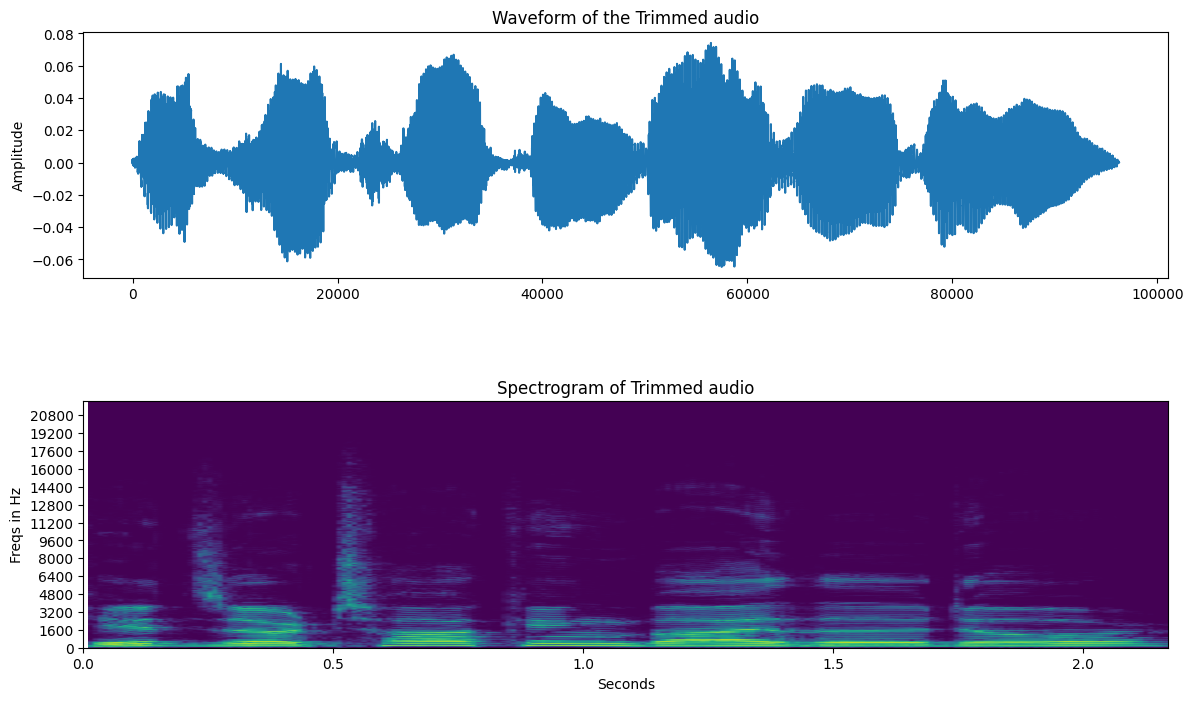

In [ ]:
# Calcul du spectrogramme du signal audio après suppression du silence
# Utilisation de la fonction log_specgram définie précédemment pour obtenir le spectrogramme
# La fonction renvoie les fréquences, les temps et le spectrogramme logarithmique du signal
freqs, times, spectrogram = log_specgram(samples_trim, sample_rate)

# Création d'une nouvelle figure pour afficher le waveform et le spectrogramme
fig = plt.figure(figsize=(14, 8))

# Création du premier subplot pour afficher le waveform du signal audio après suppression du silence
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Trimmed audio')
ax1.set_ylabel('Amplitude')
ax1.plot(samples_trim)
fig.subplots_adjust(hspace=.5)

# Création du deuxième subplot pour afficher le spectrogramme du signal audio après suppression du silence
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Trimmed audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


**Wiener Filter to remove Noise**

In [ ]:
import scipy

sample_weiner = scipy.signal.wiener(samples_trim)
len(sample_weiner)


96256

In [ ]:
ipd.Audio(sample_weiner,rate=sample_rate)


In [ ]:
Diff_noise = sample_weiner-samples_trim
ipd.Audio(Diff_noise,rate=sample_rate)

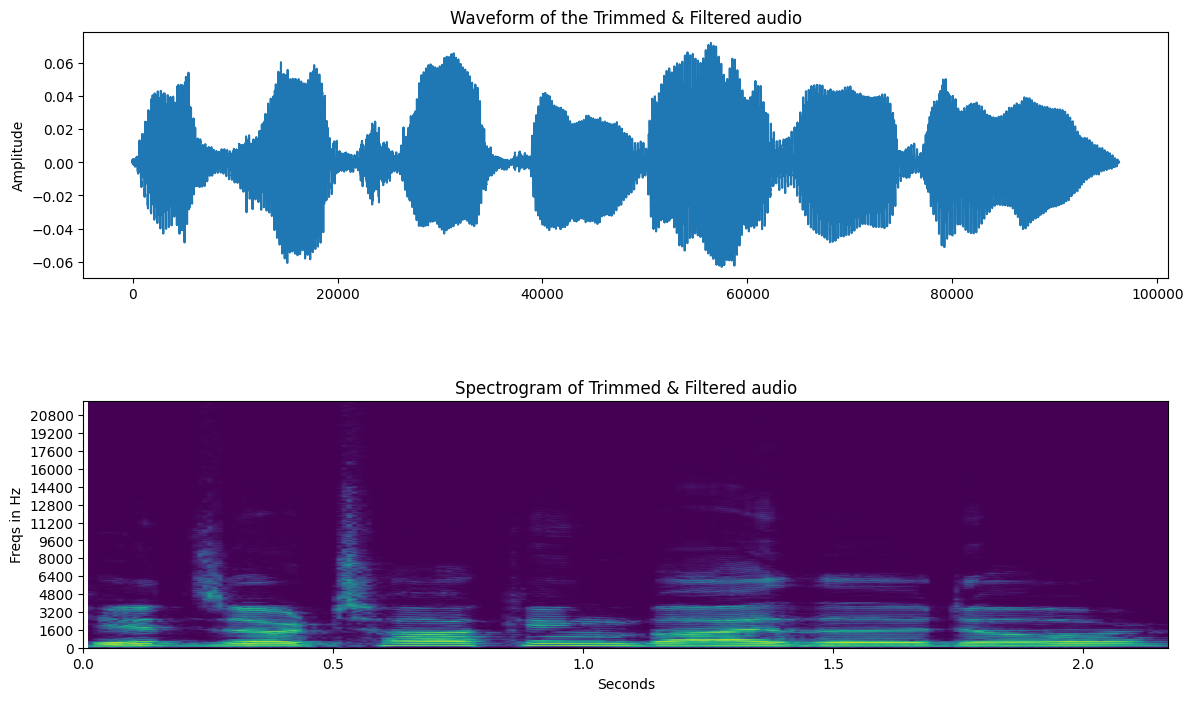

In [ ]:
freqs, times, spectrogram = log_specgram(sample_weiner, sample_rate)

fig = plt.figure(figsize=(14, 8))

# Plot the waveform
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Trimmed & Filtered audio')
ax1.set_ylabel('Amplitude')
ax1.plot(sample_weiner)

# Plot the spectrogram
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Trimmed & Filtered audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

fig.subplots_adjust(hspace=0.5)
plt.show()


**waveform of noise**

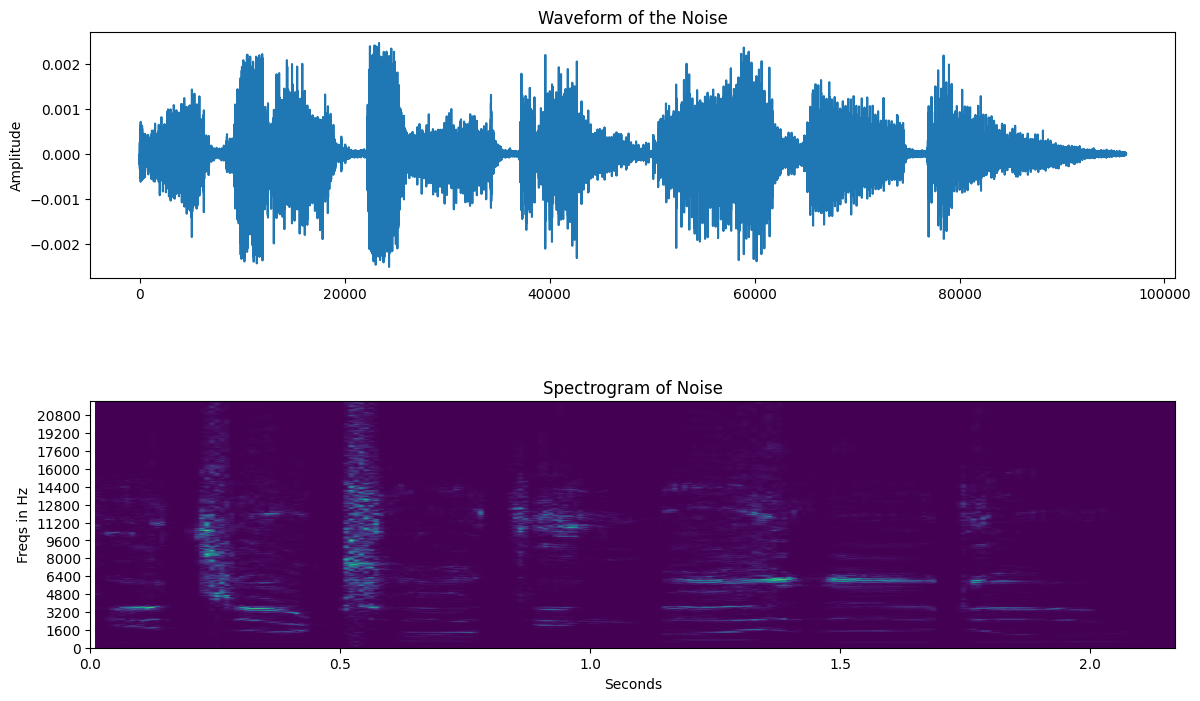

In [ ]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(Diff_noise, sample_rate)

fig = plt.figure(figsize=(14, 8))

# Plot the waveform
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Noise')
ax1.set_ylabel('Amplitude')
ax1.plot(Diff_noise)

# Plot the spectrogram
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::32])
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(0.0, end, 0.5))
ax2.set_title('Spectrogram of Noise')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

fig.subplots_adjust(hspace=0.5)
plt.show()

# **Feature Extraction**

**Zero Crossing Rate**

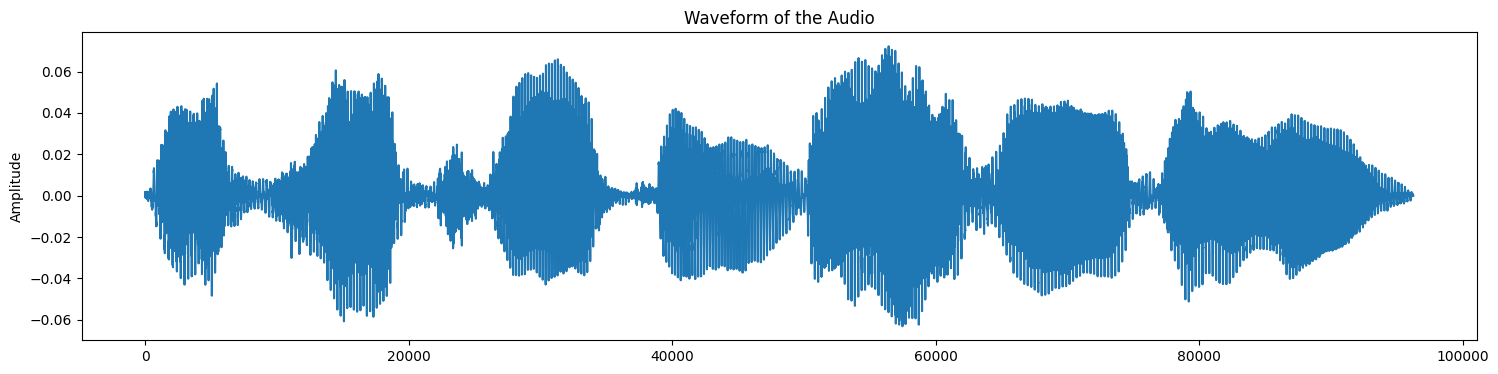

In [ ]:
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Waveform of the Audio')
ax1.set_ylabel('Amplitude')
ax1.plot(sample_weiner)  # Plot the waveform directly using matplotlib
fig.subplots_adjust(hspace=0.5)
plt.show()


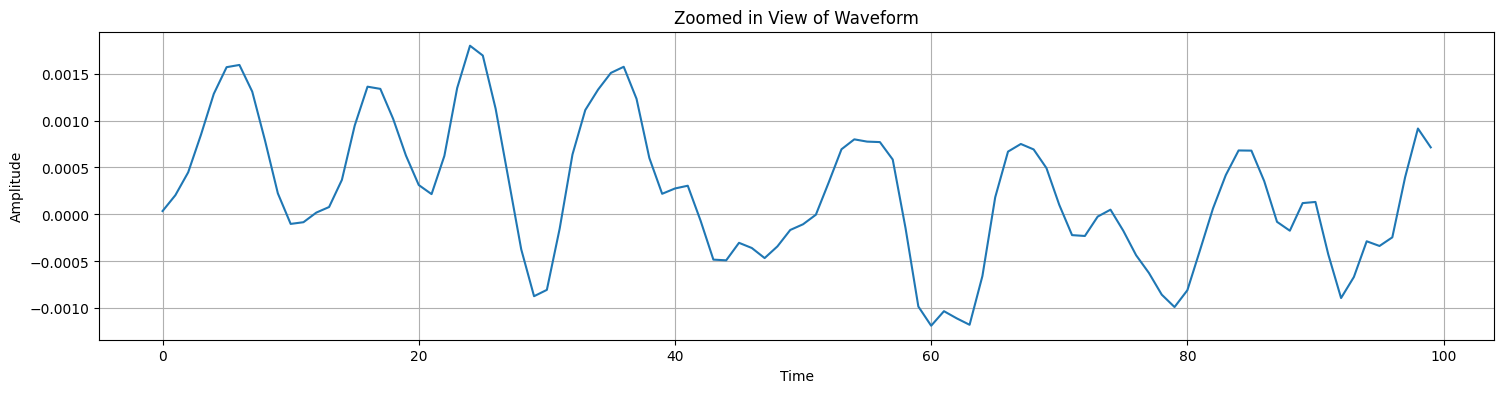

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(sample_weiner[0:100])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Zoomed in View of Waveform")
plt.grid()

In [ ]:
zero_crossings = librosa.zero_crossings(sample_weiner[0:100], pad=False)
print(sum(zero_crossings))

16


**MFCC**

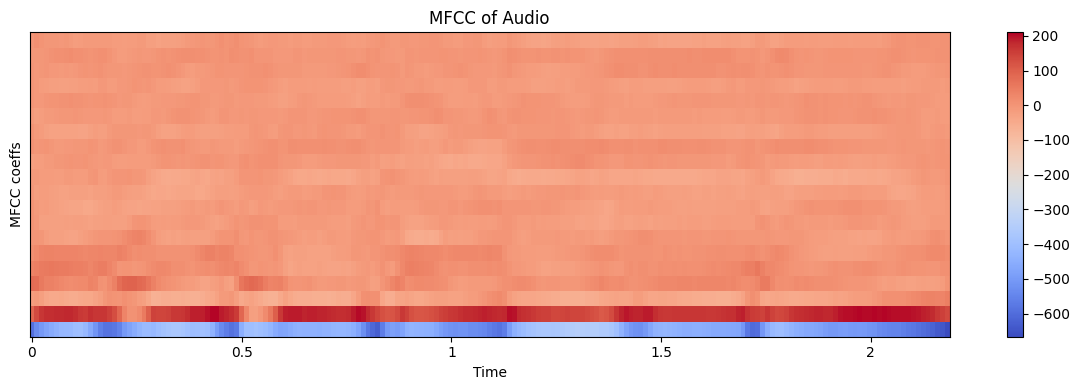

In [ ]:
mfccs = librosa.feature.mfcc(y=sample_weiner, sr=sample_rate)

plt.figure(figsize=(12, 4))
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC of Audio')
plt.colorbar()
plt.tight_layout()


In [ ]:
Male_path = "/content/drive/MyDrive/RAVDESS/Actor_09/03-02-01-01-02-01-09.wav"
Female_path = "/content/drive/MyDrive/RAVDESS/Actor_08/03-02-01-01-02-01-08.wav"

In [ ]:
# Male MFCCs
sample, sample_rate = librosa.load(Male_path, res_type='kaiser_fast', sr=22050*2)
sample, index = librosa.effects.trim(sample, top_db=25)
sample = scipy.signal.wiener(sample)

male_mfcc = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20)
mean_male_MFCC = np.mean(librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20), axis=0)

S_sample = librosa.feature.melspectrogram(y=sample, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)
Male_Mel = librosa.amplitude_to_db(S_sample, ref=np.max)


# Female MFCCs
sample, sample_rate = librosa.load(Female_path, res_type='kaiser_fast', sr=22050*2)
sample, index = librosa.effects.trim(sample, top_db=25)
sample = scipy.signal.wiener(sample)

female_mfcc = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20)
mean_female_MFCC = np.mean(librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=20), axis=0)

S_sample = librosa.feature.melspectrogram(y=sample, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)
Female_Mel = librosa.amplitude_to_db(S_sample, ref=np.max)


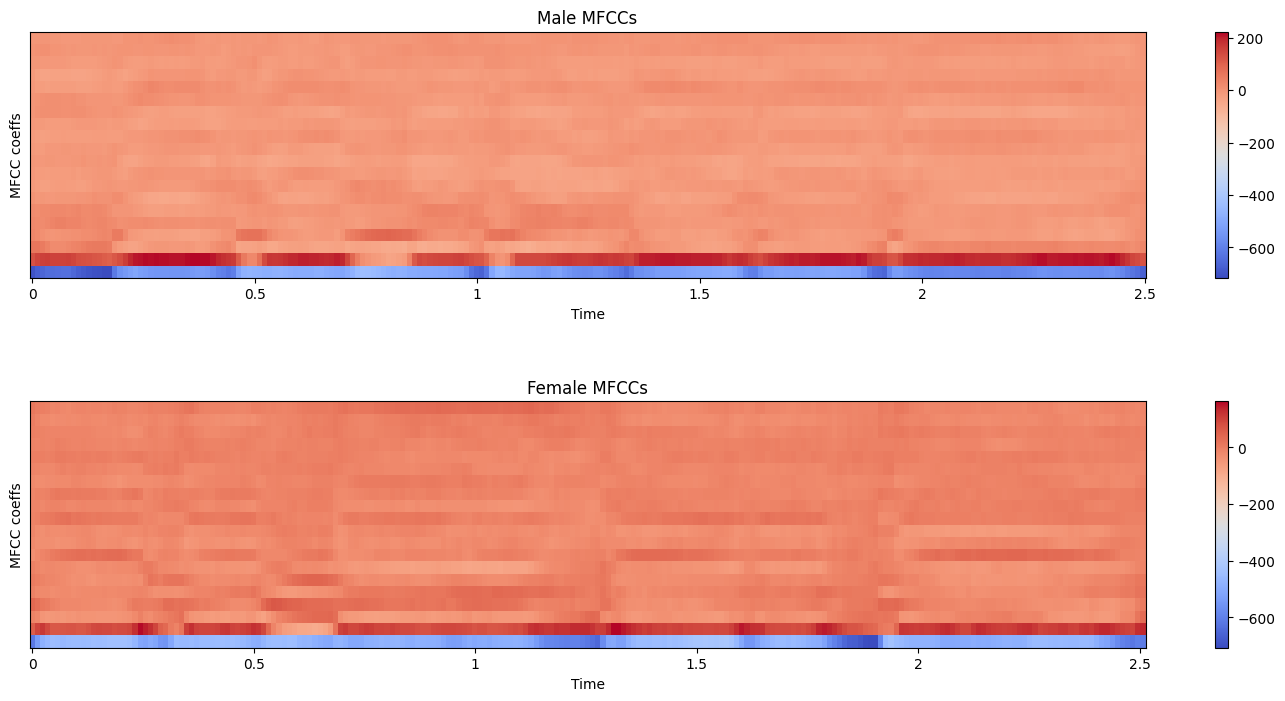

In [ ]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(211)
librosa.display.specshow(male_mfcc, sr=sample_rate, x_axis='time')
ax1.set_title('Male MFCCs')
ax1.set_ylabel('MFCC coeffs')
ax1.set_xlabel('Time')
plt.colorbar()


fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
librosa.display.specshow(female_mfcc, sr=sample_rate, x_axis='time')
ax2.set_title('Female MFCCs')
ax2.set_ylabel('MFCC coeffs')
ax2.set_xlabel('Time')

plt.colorbar()

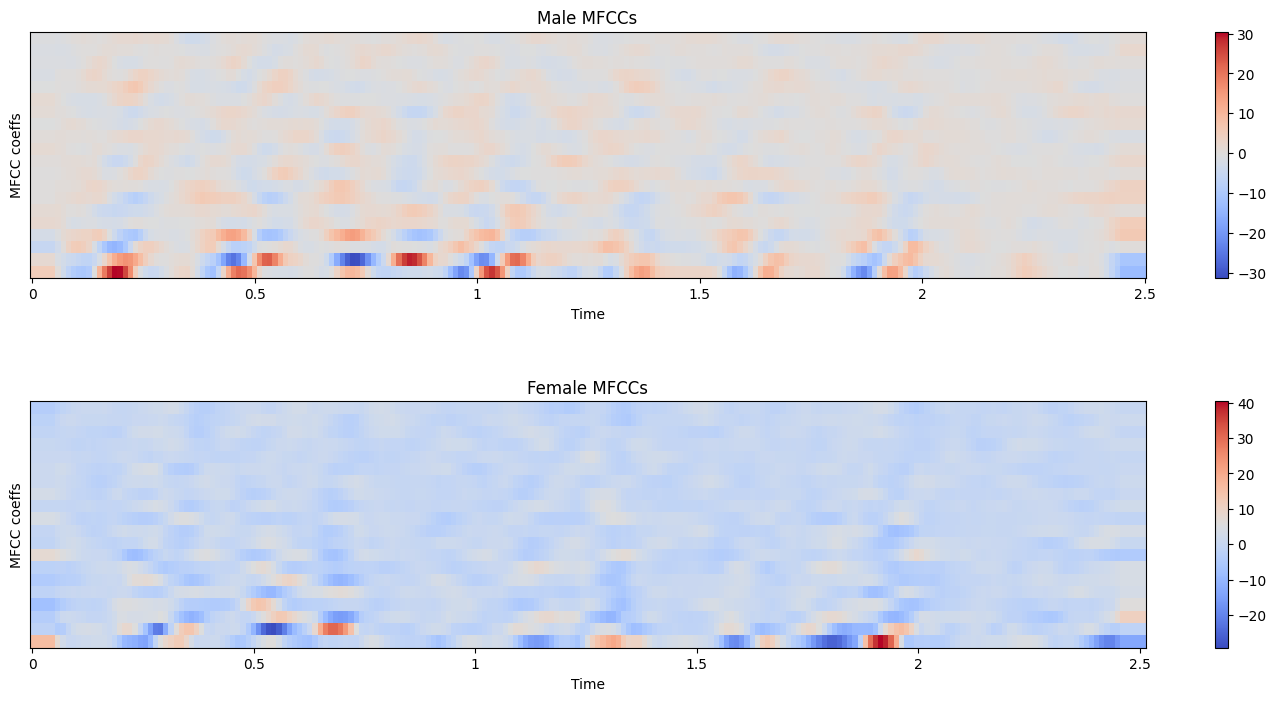

In [ ]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(211)
librosa.display.specshow(librosa.feature.delta(male_mfcc,order=1), sr=sample_rate, x_axis='time')
ax1.set_title('Male MFCCs')
ax1.set_ylabel('MFCC coeffs')
ax1.set_xlabel('Time')
plt.colorbar()


fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
librosa.display.specshow(librosa.feature.delta(female_mfcc,order=1), sr=sample_rate, x_axis='time')
ax2.set_title('Female MFCCs')
ax2.set_ylabel('MFCC coeffs')
ax2.set_xlabel('Time')

plt.colorbar()

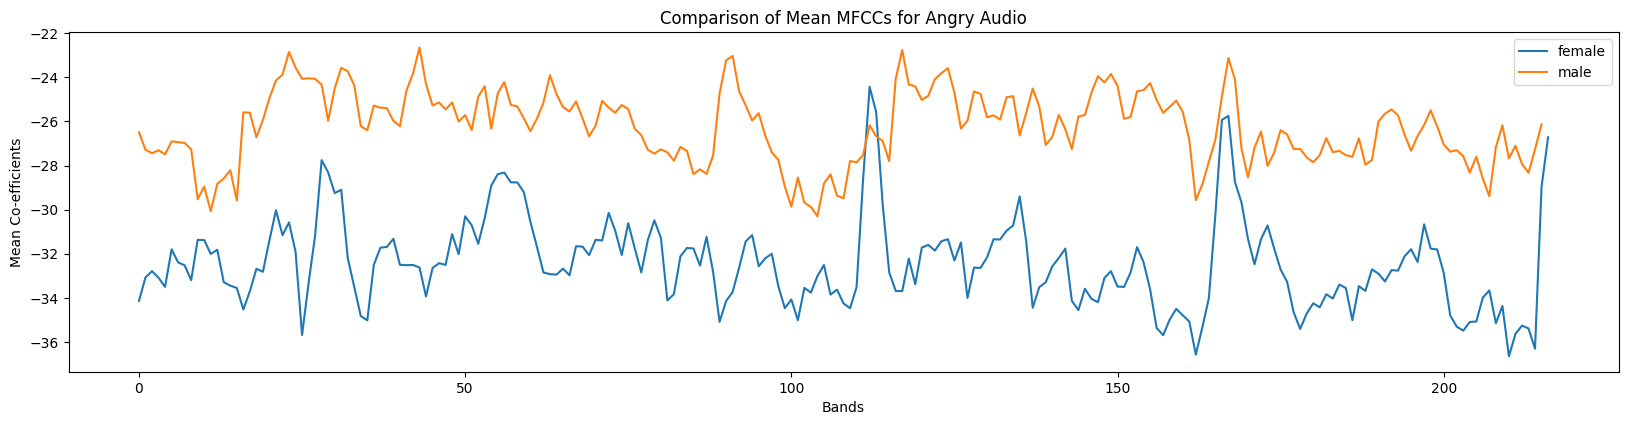

In [ ]:
# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(mean_female_MFCC, label='female')
plt.plot(mean_male_MFCC, label='male')
plt.title('Comparison of Mean MFCCs for Angry Audio')
plt.xlabel('Bands')
plt.ylabel('Mean Co-efficients')
plt.legend()


**Mel Power Spectrogram**

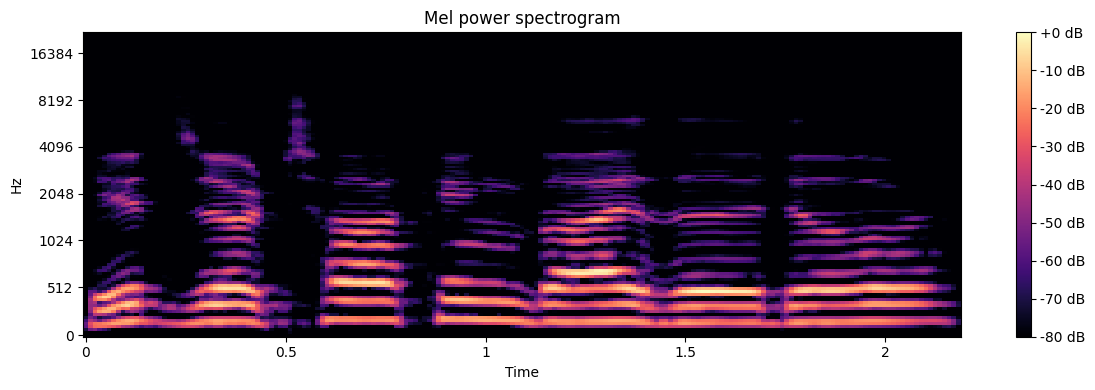

In [ ]:
S_sample = librosa.feature.melspectrogram(y=sample_weiner, sr=sample_rate, n_mels=128, n_fft=2048, hop_length=512)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S_sample = librosa.amplitude_to_db(S_sample, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S_sample, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


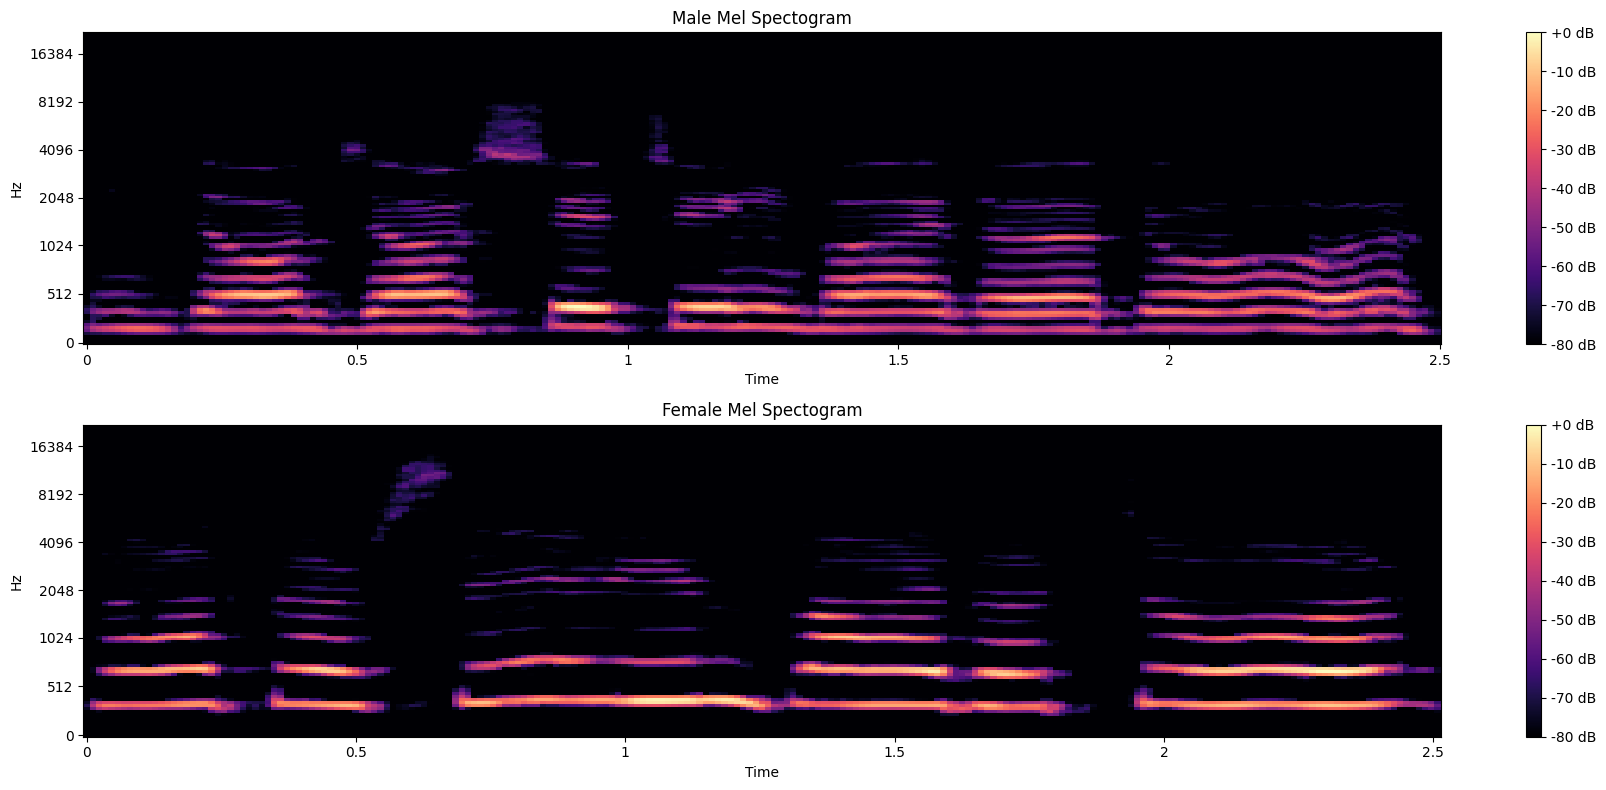

In [ ]:
fig = plt.figure(figsize=(18, 8))

ax1 = fig.add_subplot(211)
librosa.display.specshow(Male_Mel, sr=sample_rate, x_axis='time', y_axis='mel')
ax1.set_title('Male Mel Spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()


fig.subplots_adjust(hspace=.5)

ax2 = fig.add_subplot(212)
librosa.display.specshow(Female_Mel,  sr=sample_rate, x_axis='time', y_axis='mel')
ax2.set_title('Female Mel Spectogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

**Chroma**

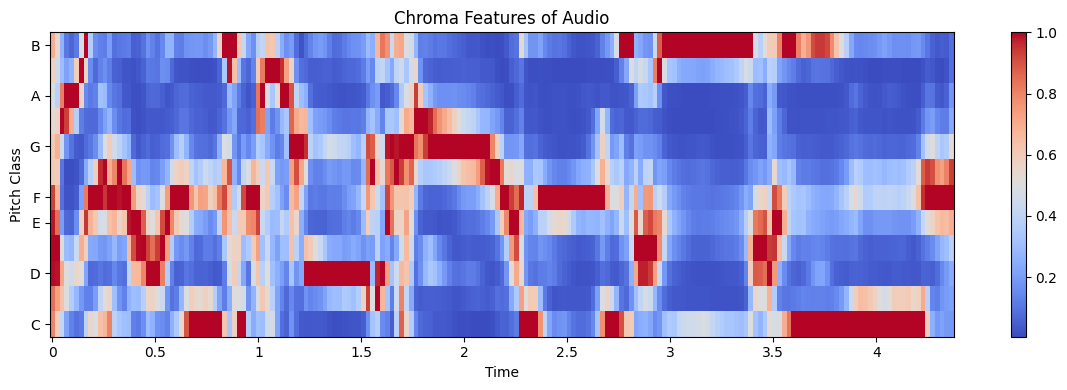

In [ ]:
hop_length = 512
chromagram = librosa.feature.chroma_stft(y=sample_weiner, sr=sample_rate, hop_length=hop_length)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.ylabel('Pitch Class')
plt.xlabel('Time')
plt.title('Chroma Features of Audio')
plt.colorbar()
plt.tight_layout()


In [ ]:
import os
import pandas as pd

Ravdess = "/content/drive/MyDrive/RAVDESS"
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        print(wav)  # Ajouter cette ligne pour voir le nom du fichier en cours de traitement
        info = wav.partition(".wav")[0].split("-")
        if len(info) >= 3:  # Assurez-vous que les informations sont correctement extraites
            emotion = int(info[2])
            emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

Ravdess_df = pd.DataFrame(emotion_df, columns=["Emotion", "Path"])

# Remplacez les codes d'émotion par les étiquettes correspondantes
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)

# Afficher les cinq premières lignes du DataFrame
Ravdess_df.head()


03-02-03-01-01-02-15.wav
03-02-02-01-02-02-15.wav
03-02-02-02-02-02-15.wav
03-02-02-01-01-02-15.wav
03-02-03-01-02-02-15.wav
03-02-01-01-02-01-15.wav
03-02-02-02-02-01-15.wav
03-02-02-01-02-01-15.wav
03-02-03-01-02-01-15.wav
03-02-03-02-01-01-15.wav
03-02-02-01-01-01-15.wav
03-02-01-01-02-02-15.wav
03-02-03-02-01-02-15.wav
03-02-02-02-01-01-15.wav
03-02-02-02-01-02-15.wav
03-02-01-01-01-02-15.wav
03-02-01-01-01-01-15.wav
03-02-03-01-01-01-15.wav
03-02-06-01-01-02-15.wav
03-02-04-01-02-01-15.wav
03-02-03-02-02-02-15.wav
03-02-06-01-02-01-15.wav
03-02-04-01-01-02-15.wav
03-02-03-02-02-01-15.wav
03-02-05-02-01-02-15.wav
03-02-06-01-02-02-15.wav
03-02-06-02-01-01-15.wav
03-02-06-02-02-02-15.wav
03-02-06-01-01-01-15.wav
03-02-04-02-02-02-15.wav
03-02-05-02-02-01-15.wav
03-02-05-02-02-02-15.wav
03-02-04-01-02-02-15.wav
03-02-05-01-02-02-15.wav
03-02-04-02-01-01-15.wav
03-02-06-02-01-02-15.wav
03-02-05-01-01-01-15.wav
03-02-04-02-02-01-15.wav
03-02-04-01-01-01-15.wav
03-02-05-01-02-01-15.wav


Emotion                                               Path
0    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
1  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
2  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
3  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
4    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...

In [ ]:
Ravdess_df.to_csv("data_path.csv",index=False)
Ravdess_df.shape

(1012, 2)

In [ ]:
Ravdess_df.head(10)


Emotion                                               Path
0    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
1  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
2  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
3  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
4    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
5  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
6  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
7  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
8    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
9    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...

**Data Visualisation and Exploration**

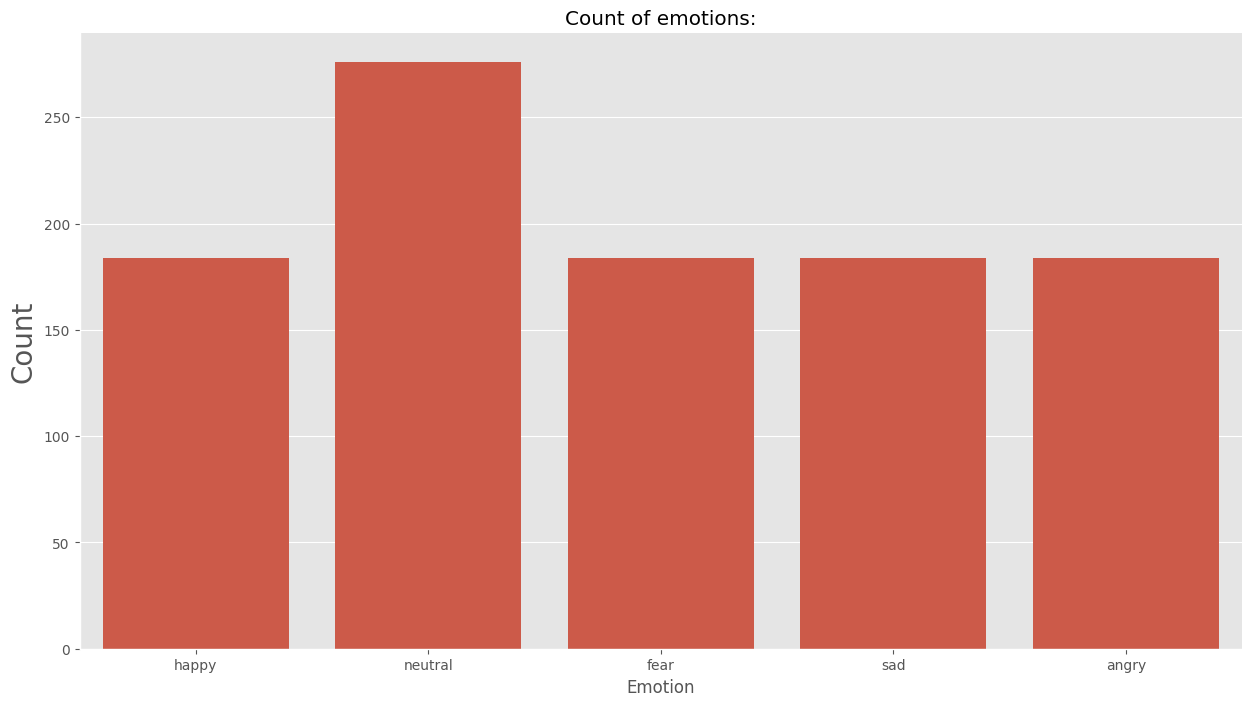

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
plt.style.use("ggplot")
plt.ylabel('Count', size=20)
plt.title("Count of emotions:")
sns.countplot(x=Ravdess_df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

**We can also plot waveplots and spectograms for audio signals.**

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

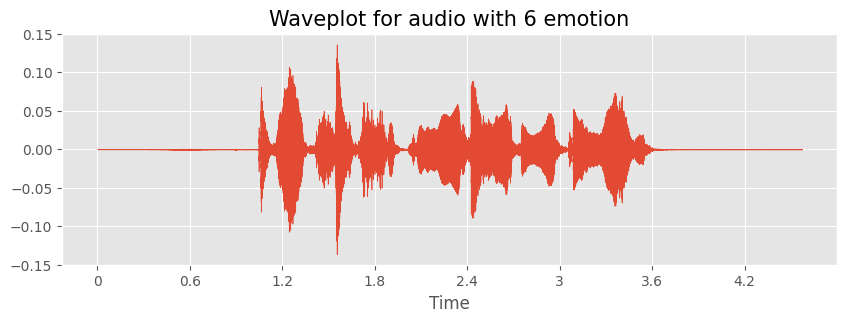

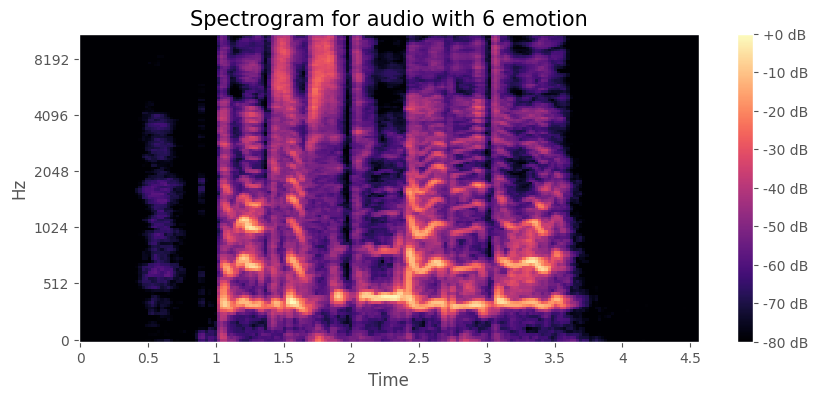

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
def create_spectrogram(data, sr, e):
    plt.figure(figsize=(10, 4))
    plt.title(f'Spectrogram for audio with {e} emotion', size=15)
    S = librosa.feature.melspectrogram(y=data, sr=sr)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
# Assuming you have already defined emotion and path
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

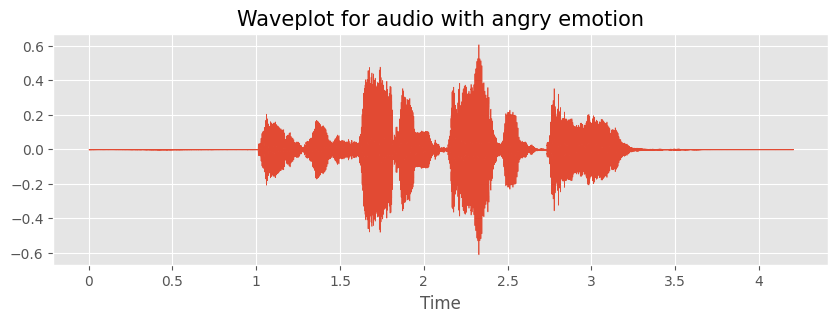

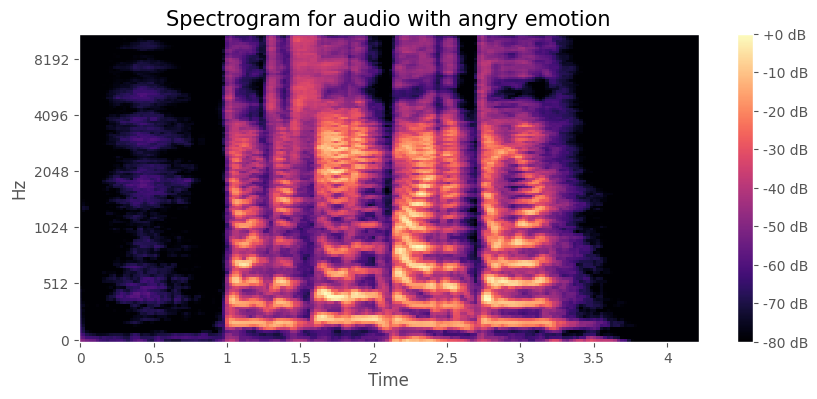

In [ ]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

*texte en italique*
**Data Augmentation**

In [ ]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
Ravdess_df.head()


Emotion                                               Path
0    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
1  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
2  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
3  neutral  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...
4    happy  /content/drive/MyDrive/RAVDESS/Actor_15/03-02-...

In [ ]:
path = Ravdess_df[Ravdess_df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

 **Noise Injection**

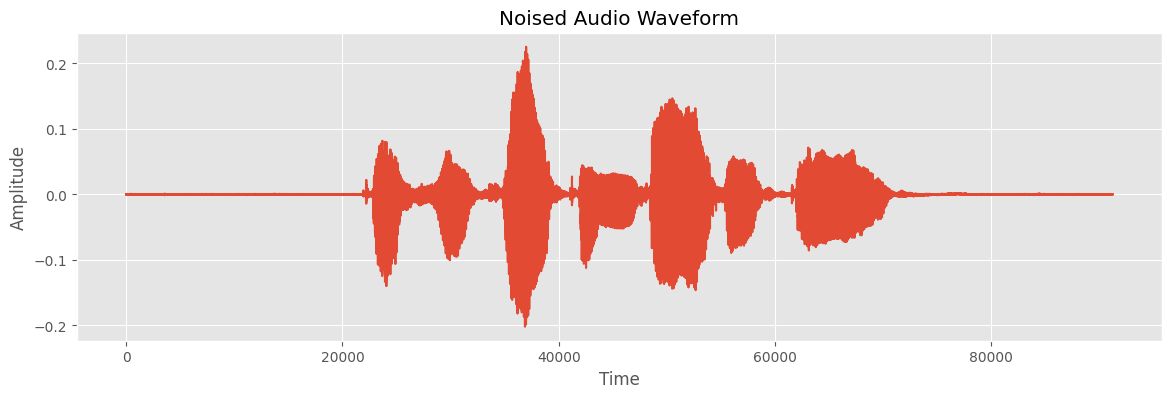

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
plt.plot(noised_data)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Noised Audio Waveform')
plt.show()


**Stretching**

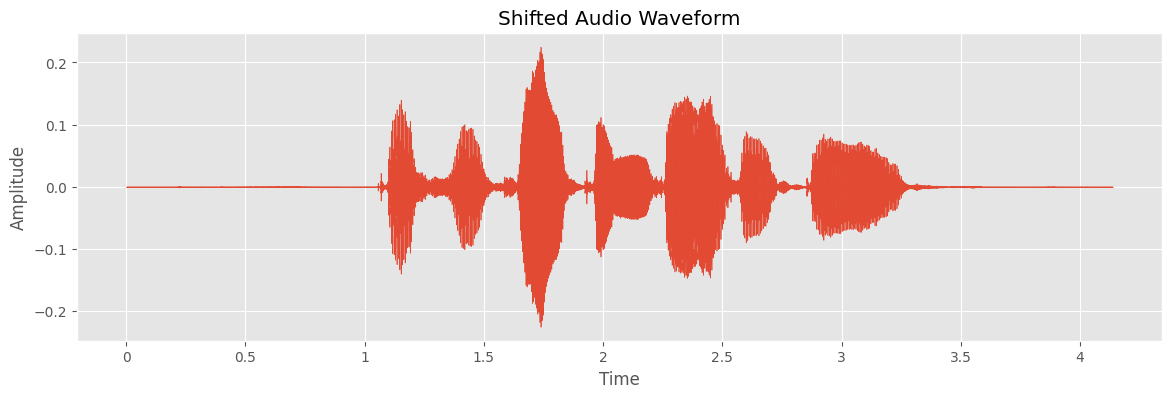

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(shifted_data, sr=sampling_rate)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Shifted Audio Waveform')
plt.show()


 **Shifting**

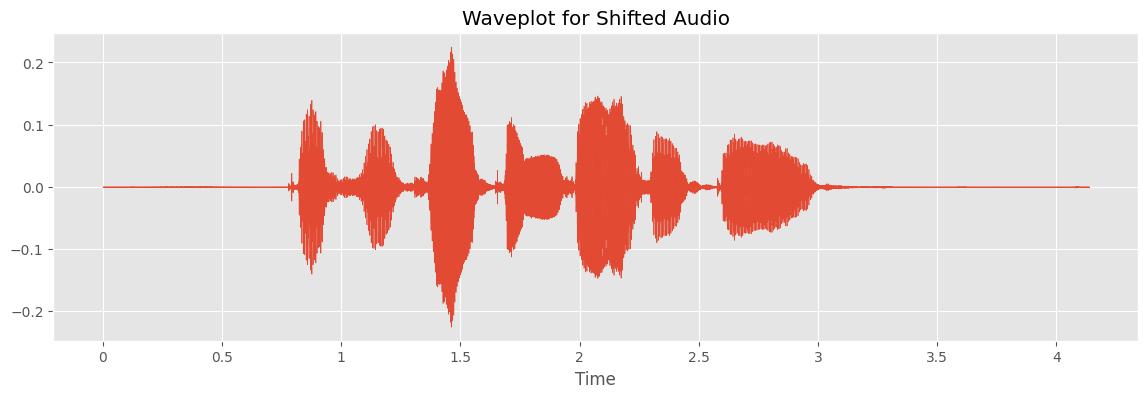

In [ ]:
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

shifted_data = shift(data)
plt.figure(figsize=(14, 4))
plt.title('Waveplot for Shifted Audio')
librosa.display.waveshow(y=shifted_data, sr=sampling_rate)
plt.show()
Audio(shifted_data, rate=sampling_rate)


 **Pitch**

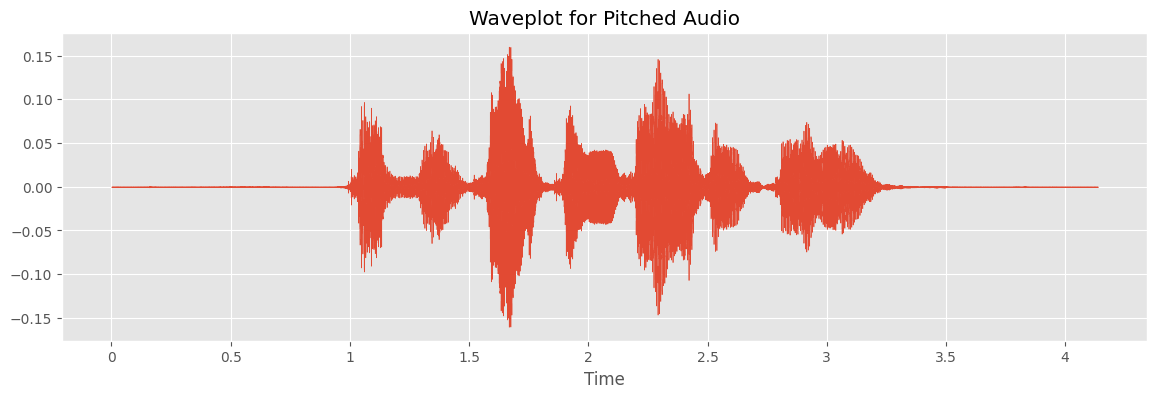

In [ ]:
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt

def pitch(data, sampling_rate, pitch_factor=0.5, random=True):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate)
plt.title('Waveplot for Pitched Audio')
plt.show()
Audio(pitched_data, rate=sampling_rate)


 **feature extraction**

In [ ]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [ ]:
import numpy as np

# Check the length of the DataFrame
num_rows = len(Ravdess_df)

# Ensure the index you're trying to access is within the valid range
if num_rows > 0:
    index_to_access = 658 % num_rows  # Ensure the index is within bounds
    path = np.array(Ravdess_df["Path"])[index_to_access]
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    len(data)
else:
    print("DataFrame is empty. Cannot access index.")


In [ ]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
Energy:  (108,)
Entropy of Energy : (108,)
RMS : (108,)
Spectral Centroid : (108,)
Spectral Flux:  ()
Spectral Rollof:  (108,)
Chroma STFT:  (1296,)
MelSpectrogram:  (13824,)
MFCC:  (2160,)


In [ ]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        np.mean(energy(data, frame_length, hop_length),axis=0),
                        np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        #spc(data, sr, frame_length, hop_length),
                        ##spc_entropy(data, sr),
                        ##spc_flux(data),
                        #spc_rollof(data, sr, frame_length, hop_length),
                        chroma_stft(data, sr, frame_length, hop_length),
                        mel_spc(data, sr, frame_length, hop_length, flatten=True),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [ ]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt

def pitch(data, sampling_rate, pitch_factor=0.5, random=True):
    if random:
        pitch_factor = np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(Ravdess_df.Path, Ravdess_df.Emotion, range(Ravdess_df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")


Feature processing...
0 samples has been processed...


<ipython-input-56-61835ed71229>:26: RuntimeWarning: divide by zero encountered in log2
  entropy -= energies * np.log2(energies)
<ipython-input-56-61835ed71229>:26: RuntimeWarning: invalid value encountered in multiply
  entropy -= energies * np.log2(energies)


100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
Done.


In [ ]:
features_path = "features.csv"


In [ ]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

0         1         2         3         4         5         6  \
0  0.145020  0.196777  0.257812  0.258301  0.266113  0.290039  0.313965   
1  0.249512  0.366699  0.487305  0.495117  0.500000  0.513672  0.523926   
2  0.134277  0.188965  0.240723  0.218750  0.216797  0.214355  0.214844   
3  0.250000  0.372070  0.489746  0.485840  0.480469  0.474121  0.489746   
4  0.235352  0.301270  0.398438  0.295898  0.321289  0.331055  0.346680   

          7         8         9  ...      17489      17490     17491  \
0  0.335449  0.348633  0.356934  ...  15.472776  22.618912 -8.684052   
1  0.510742  0.516602  0.517578  ...   9.709499   9.407334 -3.219560   
2  0.192871  0.172363  0.150879  ...  10.488274  23.363392 -9.295983   
3  0.494141  0.491211  0.497559  ...   7.315358  18.366136 -5.399499   
4  0.391113  0.375488  0.398438  ...  14.474898  -3.153167 -2.120455   

       17492      17493      17494      17495     17496     17497   labels  
0  -1.938704  11.943792  -4.267243 -15.475254  0.249880 -2.378199    happy  
1  -2.410080   1.707953  -4.607608  -8.469924 -3.505293 -3.361218    happy  
2  -4.335709   6.218453  -7.303800 -15.418674  3.570208 -2.664079    happy  
3  -5.456153   6.146273 -10.146661 -14.598285  2.397586 -2.082374    happy  
4  15.193609   5.757786  -9.226295  -2.326349 -6.381044 -9.695686  neutral  

[5 rows x 17499 columns]

In [ ]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(4048, 17499)


In [ ]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
17494     False
17495     False
17496     False
17497     False
labels    False
Length: 17499, dtype: bool


(4048, 17499)

In [ ]:
X = extracted_df.drop(labels="labels", axis=1)
y = extracted_df["labels"]

In [ ]:
X.shape, y.shape


((4048, 17498), (4048,))

In [ ]:
np.unique(y)


array(['angry', 'fear', 'happy', 'neutral', 'sad'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print((X_train.shape[0], X_test.shape[0]))

(3238, 810)


In [ ]:
from sklearn.svm import SVC

svclassifier = SVC(kernel = 'linear')

In [ ]:
import time

starting_time = time.time()
svclassifier.fit(X_train, y_train)
print("Trained model in %s ms " % str(time.time() - starting_time))

Trained model in 89.70299816131592 ms 


In [ ]:
y_pred = svclassifier.predict(X_test)


              precision    recall  f1-score   support

       angry       0.99      0.99      0.99       148
        fear       0.97      0.97      0.97       150
       happy       0.98      0.99      0.99       143
     neutral       0.98      0.97      0.98       240
         sad       0.95      0.94      0.94       129

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810

----accuracy score 97.4074074074074 ----


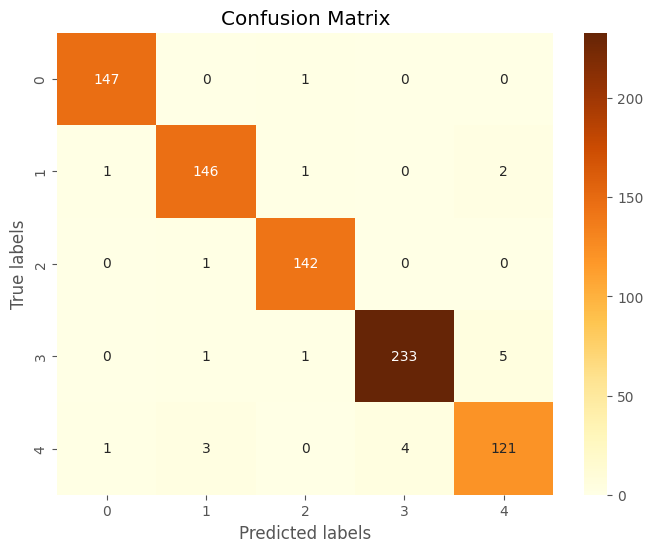

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm)

# Plot confusion matrix with colors
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='YlOrBr', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
X.shape, y.shape


((4048, 17498), (4048,))

In [ ]:
print((X_train.shape[0], X_test.shape[0]))


(3238, 810)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

 # create regressor object
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0)

# fit the regressor with x and y data
classifier.fit(X_train, y_train)

c_p = classifier.predict(X_test)


print(accuracy_score(y_true=y_test,y_pred=c_p))
print(classification_report(y_test,c_p))


0.9358024691358025
              precision    recall  f1-score   support

       angry       0.92      0.97      0.94       148
        fear       0.93      0.87      0.90       150
       happy       0.95      0.97      0.96       143
     neutral       0.95      0.95      0.95       240
         sad       0.94      0.91      0.92       129

    accuracy                           0.94       810
   macro avg       0.93      0.93      0.93       810
weighted avg       0.94      0.94      0.94       810

